# Predicting Horses health outcome 

In this notebook, we will conduct an in-depth analysis of horse health data with the goal of predicting their health outcomes. We will commence by embarking on an exploratory analysis, followed by the training phase utilizing the provided dataset.

## 0. Importing libraries

In [43]:
import pandas as pd

import math
import numpy as np

from scipy.stats import chi2, chi2_contingency, f

import statsmodels.api as sm
from statsmodels.formula.api import ols

import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns

import matplotlib.pyplot as plt

from dash import Dash, dcc, html, Input, Output

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay

import parfit.parfit as pf

import xgboost as xgb

import keras.utils as ku

import tensorflow as tf
tf.random.set_seed(42)

from keras import regularizers
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


## 1. Loading the data 

The data we will analyze is provided by Kaggle and constitutes a beginner competition dataset. You can access it through the following link: [Kaggle Playground Series S3E22](https://www.kaggle.com/competitions/playground-series-s3e22).


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df['binary_outcome'] = train_df.outcome.map({'died': 'died', 'euthanized': 'died', 'lived': 'lived'})
train_df = train_df.drop('id', axis = 1)
train_df = train_df.drop('hospital_number', axis = 1)
train_df.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome,binary_outcome
0,yes,adult,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,8.5,serosanguious,3.4,yes,2209,0,0,no,died,died
1,yes,adult,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,...,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized,died
2,yes,adult,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,...,6.4,serosanguious,3.4,yes,5124,0,0,no,lived,lived
3,yes,adult,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,...,7.0,cloudy,3.9,yes,2208,0,0,yes,lived,lived
4,no,adult,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,...,7.3,cloudy,2.6,no,0,0,0,yes,lived,lived


We have introduced a binary outcome to facilitate a comparative analysis of both scenarios. In this particular instance, we substituted the 'euthanized' label with 'died'.

## 2. Exploratory analysis

In this section, we will embark on a comprehensive exploration of the dataset, aiming to discern various facets of the data.

In [3]:
nbr_lin = len(train_df)
nbr_col = len(train_df.columns)
missing_counts = train_df.isna().sum()
print("\nNumber of Missing Values {}".format(missing_counts.unique()))
print('Number of rows: {}'.format(nbr_lin))
print('Number of columns: {}'.format(nbr_col))


Number of Missing Values [0]
Number of rows: 1235
Number of columns: 28


### 2.1 Target Balance

In [4]:
value_counts_multi = train_df.outcome.value_counts()
value_counts_binary = train_df.binary_outcome.value_counts()


trace1 = go.Pie(
     values = value_counts_multi.values,
     labels = value_counts_multi.index,
     domain=dict(x=[0, 0.5]),
     name="Multiclass outcome")

trace2 = go.Pie(
     values=value_counts_binary.values,
     labels=value_counts_binary.index,
     domain=dict(x=[0.5, 1.0]),
     name="Binary Outcome")

layout = go.Layout(title="Multiclass and Binary outcome balance", title_x=0.5)
data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)

fig.show()


On the left-hand side, we observe that the data is divided into three unbalanced sections, with the 'lived' targets comprising half of the data, while the other two outcomes, 'euthanized' and 'died,' collectively share the remaining half. Upon binarizing the outcomes, we note on the right-hand side that the data is relatively more balanced.

### 2.2 Correlation analysis

#### 2.2.1 Correlation Matrix (quantitative & quantitative)

In [5]:
numerical = train_df.select_dtypes(include=np.number).columns.to_list()
numerical = [x for x in numerical if x not in ['lesion_1', 'lesion_2', 'lesion_3']]
numerical = train_df[numerical]

fig = go.Figure()
fig.add_trace(go.Heatmap(x = numerical.columns,
                         y = numerical.columns,
                         z = numerical.corr()))
fig.show()

Examining the correlation matrix, it is evident that there are no substantial correlations. The highest attainable values are 0.5 and -0.5, denoting positive and negative correlations, respectively. Nevertheless, these coefficients are relatively modest and do not furnish adequate information for drawing a definitive conclusion.

#### 2.2.2 Chi - Squared Independence test (qualitative & qualitative)

We will conduct a chi-squared test to ascertain if there is a correlation among the three lesion features.

H0: There is no significant association between the categorical variables.

H1: There is a significant association between the features.

Significant level: &alpha; = 0.05

In [6]:
results = pd.DataFrame(columns= ['Features', 'Chi-Squared Statistic', 'critical_value', 'P-value', 'Degree of Freedom'])
categorical = train_df.select_dtypes(exclude=np.number)
categorical['lesion_1'] = train_df['lesion_1']
categorical['lesion_2'] = train_df['lesion_2']
categorical['lesion_3'] = train_df['lesion_3']

cols_run = categorical.columns.to_list()
alpha = 0.05

for col_test in categorical.columns.to_list():
    cols_run.remove(col_test)
    for col in cols_run:
        contingency_table = pd.crosstab(train_df[col_test], train_df[col])
        chi2_stat, p_val, dof, _ = chi2_contingency(contingency_table)
        features = col_test + ' & ' +col
        critical_value = chi2.ppf(1 - alpha, dof)
        results.loc[len(results)] = [features, chi2_stat, critical_value, p_val, dof]

h1_chi = results.loc[(results['P-value'] < 0.05) & (results['Features'] != 'outcome & binary_outcome') & (results['Features'] != 'binary_outcome & outcome')].sort_values(by = 'P-value', ascending = True )
h1_chi.sort_values(by = 'Features', ascending= True)

,Features,Chi-Squared Statistic,critical_value,P-value,Degree of Freedom
174,abdomen & abdomo_appearance,122.797919,24.995790,5.412297e-19,15
178,abdomen & binary_outcome,76.479721,11.070498,4.567720e-15,5
176,abdomen & cp_data,45.200152,11.070498,1.321095e-08,5
179,abdomen & lesion_1,1139.214720,320.027780,6.107489e-104,280
177,abdomen & outcome,84.401802,18.307038,6.848251e-14,10
...,...,...,...,...,...
42,temp_of_extremities & pain,344.395050,36.415029,1.734572e-58,24
39,temp_of_extremities & peripheral_pulse,559.177991,26.296228,1.023819e-108,16
43,temp_of_extremities & peristalsis,313.814810,31.410433,1.209164e-54,20
47,temp_of_extremities & rectal_exam_feces,120.392645,31.410433,2.411804e-16,20


The resulting table suggests that we have identified 162 possible feature combinations that show correlation. To arrive at these results, we calculated the Chi-squared statistic, the p-value, the degrees of freedom, and the critical value. For each p-value less than the chosen significance level (alpha) and/or for each Chi-squared statistic greater than the critical value, we rejected the null hypothesis.

In [7]:
h1_chi.loc[h1_chi.Features.str.contains('outcome')].sort_values(by = 'Features', ascending= True)

,Features,Chi-Squared Statistic,critical_value,P-value,Degree of Freedom
178,abdomen & binary_outcome,76.479721,11.070498,4.567720e-15,5
177,abdomen & outcome,84.401802,18.307038,6.848251e-14,10
140,abdominal_distention & binary_outcome,128.018953,9.487729,1.032795e-26,4
139,abdominal_distention & outcome,161.164548,15.507313,9.128438e-31,8
185,abdomo_appearance & binary_outcome,157.733729,7.814728,5.651787e-34,3
184,abdomo_appearance & outcome,176.038254,12.591587,2.353804e-35,6
35,age & binary_outcome,15.270195,3.841459,9.317517e-05,1
34,age & outcome,55.361386,5.991465,9.515418e-13,2
204,binary_outcome & lesion_1,366.993720,74.468324,2.870570e-47,56
101,capillary_refill_time & binary_outcome,111.424240,7.814728,5.417641e-24,3


Examining the targets, we observe 17 features linked to the binary output and 18 features associated with multiple outcomes. In most cases, the same features correspond to both targets.

In [37]:
multi = h1_chi.loc[~h1_chi.Features.str.contains('binary_outcome')].sort_values(by = 'Features', ascending= True)
multi = multi.loc[multi.Features.str.contains('outcome')].sort_values(by = 'Features', ascending= True)
multi

,Features,Chi-Squared Statistic,critical_value,P-value,Degree of Freedom
177,abdomen & outcome,84.401802,18.307038,6.848251e-14,10
139,abdominal_distention & outcome,161.164548,15.507313,9.128438e-31,8
184,abdomo_appearance & outcome,176.038254,12.591587,2.353804e-35,6
34,age & outcome,55.361386,5.991465,9.515418e-13,2
100,capillary_refill_time & outcome,114.335670,12.591587,2.516453e-22,6
195,cp_data & outcome,79.910338,5.991465,4.443146e-18,2
85,mucous_membrane & outcome,164.047910,21.026070,7.851088e-29,12
160,nasogastric_reflux & outcome,46.651414,15.507313,1.786799e-07,8
150,nasogastric_tube & outcome,47.831760,12.591587,1.276694e-08,6
201,outcome & lesion_1,496.245699,137.701464,8.970323e-50,112


#### 2.2.3 ANOVA and regression analysis

In the final stage, we will conduct an ANOVA and regression analysis test between the categorical and continous features. This aims to determine which features may have an impact on the different outcomes and other features.

##### 2.2.3.1 ANOVA
H0: The means of the continuous variable are equal across all levels of the categorical variable.

H1: At least one of the group means of the categorical variable is different from the others.

Significant level: &alpha; = 0.05

In [9]:
results = pd.DataFrame()

for col_num in numerical.columns.to_list():
    for col_cat in categorical.columns.to_list():
        if(train_df[col_cat].nunique() <= 2):
            continue
        features = col_num + ' ~ ' + col_cat
        model = ols(features, data=train_df).fit()      
        anova_table = sm.stats.anova_lm(model)
        anova_table['index'] = anova_table.index
        anova_table['Features'] = [features, features]
        results = pd.concat([results, anova_table], ignore_index=True, axis=0)

h1_anova = results.loc[results['PR(>F)'] < 0.05]
h1_anova

,df,sum_sq,mean_sq,F,PR(>F),index,Features
2,4.0,7.161103,1.790276,2.895961,2.112978e-02,peripheral_pulse,rectal_temp ~ peripheral_pulse
4,6.0,12.718252,2.119709,3.448480,2.207486e-03,mucous_membrane,rectal_temp ~ mucous_membrane
6,3.0,9.370926,3.123642,5.071669,1.710564e-03,capillary_refill_time,rectal_temp ~ capillary_refill_time
8,6.0,21.309465,3.551578,5.844458,5.078881e-06,pain,rectal_temp ~ pain
14,3.0,5.120937,1.706979,2.756070,4.123083e-02,nasogastric_tube,rectal_temp ~ nasogastric_tube
...,...,...,...,...,...,...,...
196,4.0,65.925640,16.481410,6.645310,2.728123e-05,nasogastric_reflux,abdomo_protein ~ nasogastric_reflux
198,5.0,87.884533,17.576907,7.132595,1.373687e-06,rectal_exam_feces,abdomo_protein ~ rectal_exam_feces
200,5.0,123.139601,24.627920,10.111555,1.668595e-09,abdomen,abdomo_protein ~ abdomen
202,3.0,57.257162,19.085721,7.679802,4.369560e-05,abdomo_appearance,abdomo_protein ~ abdomo_appearance


In this anova test, we identified 83 pairs of categorical and continous (not binary) features that do have some type of association. This gives us enough proof that the dataset has in fact patterns that lead to different feature values.

In [10]:
h1_anova.loc[h1_anova.Features.str.contains('outcome')]

,df,sum_sq,mean_sq,F,PR(>F),index,Features
54,2.0,123832.054779,61916.027390,82.756048,1.893047e-34,outcome,pulse ~ outcome
84,2.0,11485.745903,5742.872952,21.937194,4.350282e-10,outcome,respiratory_rate ~ outcome
114,2.0,606.735953,303.367976,92.859293,2.733604e-38,outcome,nasogastric_reflux_ph ~ outcome
144,2.0,13338.068943,6669.034472,66.453161,3.916005e-28,outcome,packed_cell_volume ~ outcome
174,2.0,195503.660058,97751.830029,176.415388,4.233815e-68,outcome,total_protein ~ outcome
204,2.0,200.581927,100.290964,42.373511,1.594967e-18,outcome,abdomo_protein ~ outcome


We have 6 features associated to the outcome that potentially show a specific pattern.

##### 2.2.3.2 Regression Analysis (Ordinary Least Squares)

We use regression models to assess the relationship between a categorical (binary) predictor and a continuous outcome variable.

H0: There is no significant linear relationship between the features.

H1: There is a significant linear relationship between the features.

Significant level: &alpha; = 0.05 

In [11]:
results = pd.DataFrame(columns = ['Features', 'P-value', 'F-statistic', 'critical_value'])

alpha = 0.05

for col_num in numerical.columns.to_list():
    for  col_cat in categorical.columns.to_list():
        if(train_df[col_cat].nunique() > 2):
            continue
        features = col_num + ' ~ ' + col_cat
        bin = train_df[col_cat].unique().tolist()
        X = train_df[col_cat].replace(to_replace= bin, value= [0, 1])
        X = sm.add_constant(X)  # Adding a constant for the intercept term
        y = train_df[col_num]
        model = sm.OLS(y, X).fit()
        critical_value = f.ppf(1 - alpha, model.df_model, model.df_resid)
        results.loc[len(results)] = [features,model.f_pvalue, model.fvalue, critical_value]


h1 = results.loc[results['P-value'] < 0.05]
h1

,Features,P-value,F-statistic,critical_value
0,rectal_temp ~ surgery,3.818032e-02,4.306215,3.849012
1,rectal_temp ~ age,2.697202e-02,4.904313,3.849012
6,pulse ~ surgery,2.230770e-06,22.598953,3.849012
7,pulse ~ age,1.166433e-23,104.785393,3.849012
8,pulse ~ surgical_lesion,7.786796e-17,71.486415,3.849012
9,pulse ~ cp_data,1.507260e-04,14.452988,3.849012
10,pulse ~ binary_outcome,4.643549e-35,162.534296,3.849012
12,respiratory_rate ~ surgery,1.240599e-04,14.824326,3.849012
13,respiratory_rate ~ age,1.828760e-11,46.001653,3.849012
14,respiratory_rate ~ surgical_lesion,2.699893e-05,17.751934,3.849012


We observe statistical significance for 25 pairs of features. In this case we can say that there is a significant linear relationship between these pairs.

In [12]:
h1 = h1.loc[h1['Features'].str.contains('outcome')]
h1

,Features,P-value,F-statistic,critical_value
10,pulse ~ binary_outcome,4.643549e-35,162.534296,3.849012
16,respiratory_rate ~ binary_outcome,4.250085e-09,35.007401,3.849012
22,nasogastric_reflux_ph ~ binary_outcome,2.422344e-02,5.091104,3.849012
28,packed_cell_volume ~ binary_outcome,9.445925e-27,120.186915,3.849012


These 4 features represented in the table show a significant linear relationship with the binary outcome.

Faire test aussi avec données train et données test

### 2.3 Visualisation

In [13]:
x = 'packed_cell_volume'
y = 'respiratory_rate'
z = 'total_protein'
fig = px.scatter_3d(train_df, x = x, y= y , z= z , color='outcome', height= 500, width= 500)

fig.show()

In this example we can observe a slight discrimination of the euthanized horses compared to the one that died. 

In [14]:
x = 'packed_cell_volume'
y = 'respiratory_rate'
z = 'total_protein'
fig = px.scatter_3d(train_df, x = x, y= y , z= z , color='binary_outcome', height= 500, width= 500)

fig.show()

On the binary view, it is more difficult to obtain a clear discriminative view.

In [15]:
def plot_cats(df, targets, which, cols):
    cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    cat_cols = [x for x in cat_cols if x not in targets]
    col_names = [cat_cols[i:i+cols] for i in range(0, len(cat_cols), cols)]
    fig = make_subplots(rows=len(col_names), cols=cols, y_title='Count of occurences')
    colors = ['red', 'orange', 'green']  # Add more colors if needed

    for row in range(len(col_names)):
        for col in range(len(col_names[row])): 
            value_counts = df.groupby([col_names[row][col], targets[which]]).size().unstack(fill_value=0)
            for i, name in enumerate(value_counts.columns):
                if(row == 0 and col == 0):
                    fig.add_trace(go.Bar(x = value_counts.index,
                                y = value_counts[name],
                                legendgroup= name,
                                name=f'Target {name}',
                                marker_color=colors[i]
                                ),
                        row+1, col+1)
                else:
                    fig.add_trace(go.Bar(x = value_counts.index,
                                y = value_counts[name],
                                legendgroup= name,
                                showlegend=False,
                                name=f'Target {name}',
                                marker_color=colors[i],),
                        row+1, col+1)
                    
            fig.update_xaxes(title_text=col_names[row][col], row=row+1, col=col+1, tickangle=55)
    fig.update_layout(autosize=False,
                    barmode='stack',
                    width=550 * cols,
                    height=500 * len(col_names) )
    fig.show()

In [16]:
plot_cats(train_df, ["outcome", "binary_outcome"], 1, 8)

In [17]:
plot_cats(train_df, ["outcome", "binary_outcome"], 0, 8)

In this case, there are few instances indicating a clear preference for any of the specified outcomes. The only notable observation is in the dimension of pain, where a majority of higher pain indices corresponded to cases where the horse ultimately survived. Nonetheless it give us a clear view of how the different values are distributed by their corresponding targets.

In [18]:
app = Dash(__name__)

numer = train_df.select_dtypes(include=np.number).columns.tolist()
numer = [x for x in numer if x not in ['id', 'hospital_number']]

app.layout = html.Div([
    html.H4("Analysis of numerical values", style= {'backgroundColor':'white'}),
    html.P("x-axis:", style = {'backgroundColor':'white'}),
    dcc.Checklist(
        id='x-axis', 
        options= ['outcome', 'binary_outcome'],
        value=['outcome'], 
        inline=True,
        style = {'backgroundColor':'white'}
    ),
    html.P("y-axis:", style = {'backgroundColor':'white'}),
    dcc.RadioItems(
        id='y-axis', 
        options=numer,
        value='rectal_temp', 
        inline=True,
        style = {'backgroundColor':'white'}
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("x-axis", "value"), 
    Input("y-axis", "value"))
def generate_chart(x, y):
    df = train_df
    fig = px.box(df, x=x, y=y, template='plotly_white')
    return fig


app.run_server(debug=True, port=8051)

In summary, visualizing the data based on outcomes proves to be challenging, as discerning simple patterns with the naked eye is not straightforward. While there are some minor details available, they lack significance. 

## 3. Exploratory analysis

### 0. Data preparation

<AxesSubplot:>

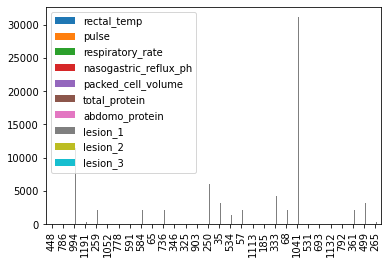

In [19]:
train_df.sample(n = 30).plot(kind= 'bar')

With a very simple plot, we can see that the data needs some scaling.

In [20]:
def scale_data(df):

    numerical = df.select_dtypes(include=np.number).columns.to_list()
    
    scaler = MinMaxScaler()
  
    min_max_scaled = df.copy()

    min_max_scaled[numerical] = scaler.fit_transform(min_max_scaled[numerical])

    return min_max_scaled

<AxesSubplot:>

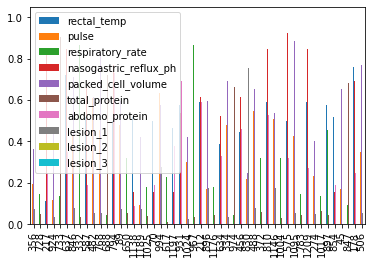

In [21]:
train_min_max_scaled = scale_data(train_df)

train_min_max_scaled.sample(n = 50).plot(kind= 'bar')

We will have different cases basod on the encoding method we want to use.

In [22]:
y_multi = train_min_max_scaled.outcome.map({'died': 1, 'lived': 0, 'euthanized': 2 })
y_binary = train_min_max_scaled.binary_outcome.map({'died': 1, 'lived': 0})
X = train_min_max_scaled.drop('outcome', axis = 1)
X = X.drop('binary_outcome', axis = 1)

### 1. SGD Classifier

This training example already includes optimization

In [23]:
def count_encoder(df):
    df_enc = df.copy(deep = True)
    cat_cols = df_enc.select_dtypes(exclude=np.number).columns.tolist()
    for cat in cat_cols:
        count_map = df_enc[cat].value_counts().to_dict()
        df_enc[cat] = df_enc[cat].map(count_map)
    df_enc[cat_cols] = scale_data(df_enc[cat_cols])

    return df_enc

In [40]:
def train_pred_SGD(X_train, y_train, X_test, y_test, acc_score, alpha = 0.001, loss='log', n_jobs=-1, avg = None, penalty= 'l1'):

    model = SGDClassifier(loss=loss, n_jobs = n_jobs, alpha = alpha, penalty = penalty)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf).plot()
    print("score: {}".format(acc_score(y_test, y_pred)))
    print("F1: {}".format(f1_score(y_test, y_pred, average=avg)))
    print("Precision: {}".format(precision_score(y_test, y_pred, average=avg)))
    print("Recall {}".format(recall_score(y_test, y_pred, average=avg)))

In [25]:
X_count_enc = count_encoder(X)

X_train_multi_enc, X_test_multi_enc, y_train_multi_enc, y_test_multi_enc = train_test_split(X_count_enc ,y_multi , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)

X_train_binary_enc, X_test_binary_enc, y_train_binary_enc, y_test_binary_enc = train_test_split(X_count_enc ,y_binary , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)

In [26]:
def grid_parfit(X_train, y_train, X_test, y_test,  acc_score=accuracy_score):

    grid = {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
        'loss': ['log'],
        'penalty': ['l1','l2'],
        'n_jobs': [-1],
        'random_state' : [42]
    }
    paramGrid = ParameterGrid(grid)

    bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
                                                            X_train, y_train, X_test, y_test, 
                                                            metric = acc_score,
                                                            scoreLabel = "accuracy")

    print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:   27.5s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   27.6s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   27.6s remaining:   35.5s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   27.6s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:   27.6s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   27.6s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   27.7s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


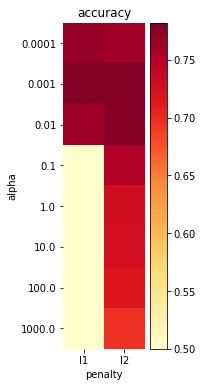

SGDClassifier(alpha=0.001, loss='log', n_jobs=-1, penalty='l1', random_state=42) 0.7822147651006711


In [39]:
grid_parfit(X_train_binary_enc, y_train_binary_enc, X_test_binary_enc, y_test_binary_enc, acc_score = roc_auc_score)

score: 0.7087378640776699
F1: 0.7457627118644068
Precision: 0.6804123711340206
Recall 0.825


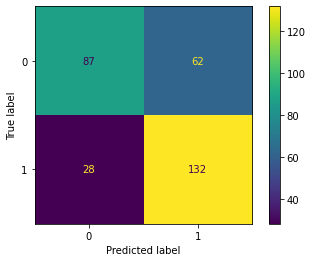

In [46]:
train_pred_SGD(X_train_binary_enc, y_train_binary_enc, X_test_binary_enc, y_test_binary_enc, acc_score=accuracy_score, avg = 'binary', alpha=0.001, loss='log', n_jobs=-1, penalty='l1')

-------------FITTING MODELS-------------


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0745s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


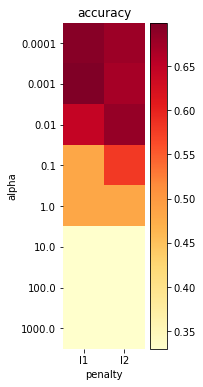

SGDClassifier(alpha=0.001, loss='log', n_jobs=-1, penalty='l1', random_state=42) 0.6990291262135923


In [ ]:
grid_parfit(X_train_multi_enc, y_train_multi_enc, X_test_multi_enc, y_test_multi_enc, acc_score = accuracy_score)

score: 0.6925566343042071
F1: 0.6925566343042071
Precision: 0.6925566343042071
Recall 0.6925566343042071


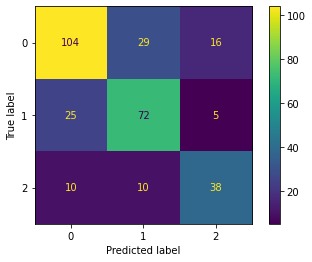

In [47]:
train_pred_SGD(X_train_multi_enc, y_train_multi_enc, X_test_multi_enc, y_test_multi_enc, acc_score=accuracy_score, avg = 'micro', alpha=0.001, loss='log', n_jobs=-1, penalty='l1')

We attained a score of 0.69 for the multiclass outcome and a score of 0.73 for the binary outcome, showcasing not too bad performance. When it comes to precision and recall, our focus might lean towards the latter. Given the professional application, it could be prudent to refine the results even more. Exploring alternative models may present opportunities for further enhancement.

### 2. Neural Network

In [ ]:
X_enc_one_hot = pd.get_dummies(X)
y_multi_seq = ku.to_categorical(train_min_max_scaled.outcome.map({'died': 1, 'lived': 0, 'euthanized': 2 }))
X_train_binary_one_hot, X_test_binary_one_hot, y_train_binary_one_hot, y_test_binary_one_hot = train_test_split(X_enc_one_hot ,y_binary , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)
X_train_multi_one_hot, X_test_multi_one_hot, y_train_multi_one_hot, y_test_multi_one_hot = train_test_split(X_enc_one_hot ,y_multi_seq , 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)

In [ ]:
input_dim = len(X_train_binary_one_hot.columns)

model = Sequential()

model.add(Dense(250, activation = 'relu', input_dim = input_dim))

model.add(Dropout(0.75))

model.add(Dense(15, activation = 'relu'))

model.add(Dropout(0.50))

model.add(Dense(3, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid' ))

model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [reduce_lr, early]


history = model.fit(X_train_binary_one_hot, y_train_binary_one_hot, verbose = 1, epochs = 100, batch_size = 12, callbacks= callbacks, validation_data=(X_test_binary_one_hot, y_test_binary_one_hot))

Epoch 1/100
78/78 [==============================] - 2s 8ms/step - loss: 0.6933 - accuracy: 0.5691 - val_loss: 0.6591 - val_accuracy: 0.7249 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - 0s 5ms/step - loss: 0.6773 - accuracy: 0.6037 - val_loss: 0.6456 - val_accuracy: 0.7055 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.6577 - val_loss: 0.6320 - val_accuracy: 0.7314 - lr: 0.0010
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6728 - val_loss: 0.5935 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 5/100
78/78 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6717 - val_loss: 0.5835 - val_accuracy: 0.7443 - lr: 0.0010
Epoch 6/100
78/78 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.6847 - val_loss: 0.5615 - val_accuracy: 0.7573 - lr: 0.0010
Epoch 7/100
78/78 [==============================] - 0s 4ms/step - loss: 0.5

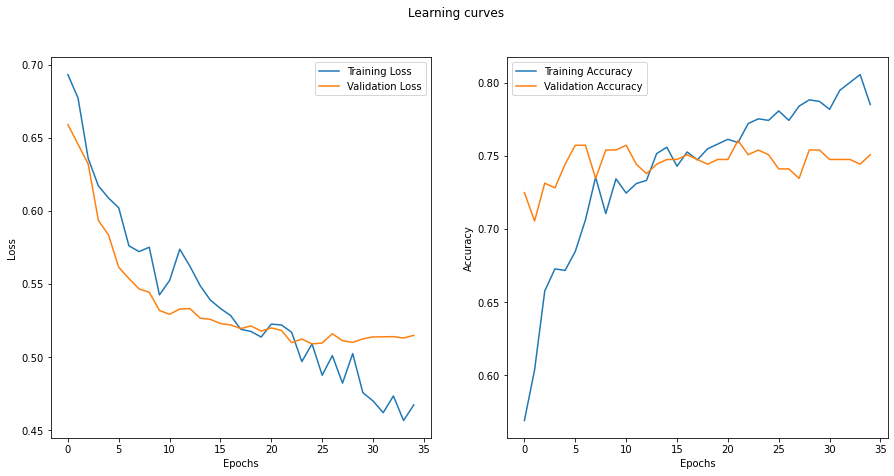

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.epoch, loss_train, label='Training Loss')
ax[0].plot(history.epoch, loss_val, label='Validation Loss')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(history.epoch, accuracy_train, label='Training Accuracy')
ax[1].plot(history.epoch, accuracy_val, label='Validation Accuracy')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

fig.suptitle('Learning curves')
fig.set_figheight(7)
fig.set_figwidth(15)
ax[0].legend()
ax[1].legend()

plt.show()

26/26 [==============================] - 0s 2ms/step
score: 0.7508090614886731
F1: 0.7687687687687689
Precision: 0.7398843930635838
Recall 0.8


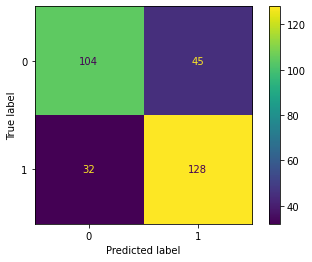

In [ ]:
y_pred = model.predict(X_test_binary_one_hot, batch_size = 12)
y_pred = pd.Series(y_pred.ravel())
tresh = 0.5
y_pred = np.where(y_pred >= tresh, 1, 0)
conf = confusion_matrix(y_test_binary_one_hot, y_pred)
ConfusionMatrixDisplay(conf).plot()
print("score: {}".format(accuracy_score(y_test_binary_one_hot, y_pred)))
print("F1: {}".format(f1_score(y_test_binary_one_hot, y_pred, average='binary')))
print("Precision: {}".format(precision_score(y_test_binary_one_hot, y_pred, average='binary')))
print("Recall {}".format(recall_score(y_test_binary_one_hot, y_pred, average='binary')))

We have a slight performance boost using the custom Neural Network architecture

In [ ]:
input_dim = len(X_train_multi_one_hot.columns)

model = Sequential()

model.add(Dense(250, activation = 'relu', input_dim = input_dim))

model.add(Dropout(0.75))

model.add(Dense(3, activation = 'relu'))

model.add(Dense(3, activation = 'softmax' ))

model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [reduce_lr, early]


history = model.fit(X_train_multi_one_hot, y_train_multi_one_hot, verbose = 1, epochs = 100, batch_size = 12, callbacks= callbacks, validation_data=(X_test_multi_one_hot, y_test_multi_one_hot))

Epoch 1/100
78/78 [==============================] - 2s 6ms/step - loss: 0.6029 - accuracy: 0.4946 - val_loss: 0.5291 - val_accuracy: 0.5761 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - 0s 4ms/step - loss: 0.5347 - accuracy: 0.6004 - val_loss: 0.4870 - val_accuracy: 0.6537 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - 0s 4ms/step - loss: 0.5000 - accuracy: 0.6285 - val_loss: 0.4605 - val_accuracy: 0.6537 - lr: 0.0010
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.4801 - accuracy: 0.6674 - val_loss: 0.4483 - val_accuracy: 0.6764 - lr: 0.0010
Epoch 5/100
78/78 [==============================] - 0s 5ms/step - loss: 0.4772 - accuracy: 0.6609 - val_loss: 0.4406 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 6/100
78/78 [==============================] - 0s 5ms/step - loss: 0.4558 - accuracy: 0.6825 - val_loss: 0.4411 - val_accuracy: 0.6926 - lr: 0.0010
Epoch 7/100
78/78 [==============================] - 0s 5ms/step - loss: 0.4

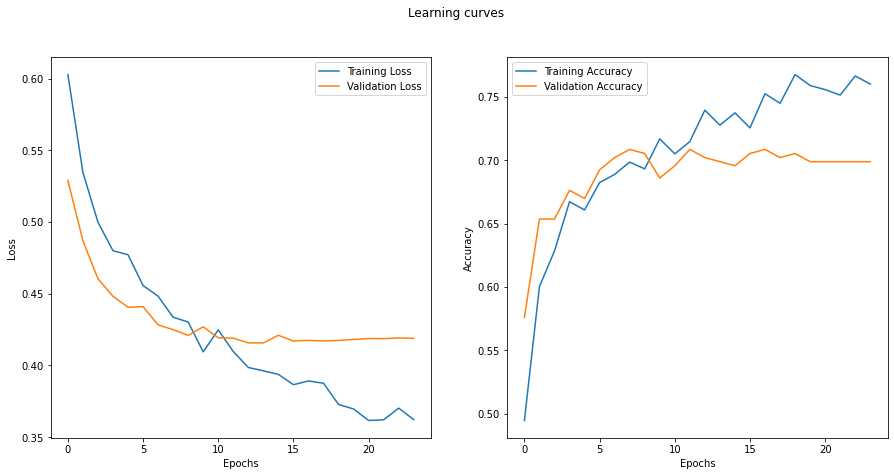

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.epoch, loss_train, label='Training Loss')
ax[0].plot(history.epoch, loss_val, label='Validation Loss')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(history.epoch, accuracy_train, label='Training Accuracy')
ax[1].plot(history.epoch, accuracy_val, label='Validation Accuracy')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

fig.suptitle('Learning curves')
fig.set_figheight(7)
fig.set_figwidth(15)
ax[0].legend()
ax[1].legend()


plt.show()

26/26 [==============================] - 0s 2ms/step
score: 0.6990291262135923
F1: 0.6820907224678491
Precision: 0.679297721821884
Recall 0.685249722815918


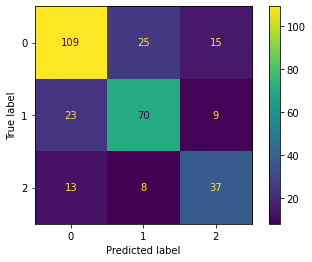

In [ ]:
y_pred = model.predict(X_test_multi_one_hot, batch_size = 12)
y_pred = np.argmax(y_pred, axis=1)
#y_pred = y_pred.tolist()
y_test_multi_one_hot_arg = np.argmax(y_test_multi_one_hot, axis=1)
conf = confusion_matrix(y_test_multi_one_hot_arg, y_pred)
ConfusionMatrixDisplay(conf).plot()
print("score: {}".format(accuracy_score(y_test_multi_one_hot_arg, y_pred)))
print("F1: {}".format(f1_score(y_test_multi_one_hot_arg, y_pred, average='macro')))
print("Precision: {}".format(precision_score(y_test_multi_one_hot_arg, y_pred, average='macro')))
print("Recall {}".format(recall_score(y_test_multi_one_hot_arg, y_pred, average='macro')))

When training on the multiclass task, we cannot reach better results.

### 3. XGBoost

In [ ]:
def train_pred_xgb_optim(X_train, y_train, X_test, y_test, avg, subsample, reg_lambda, n_estimators, max_depth, learning_rate, gamma):

    model = xgb.XGBClassifier(subsample = subsample, reg_lambda = reg_lambda, n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, gamma = gamma)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf).plot()
    print("score: {}".format(accuracy_score(y_test, y_pred)))
    print("F1: {}".format(f1_score(y_test, y_pred, average=avg)))
    print("Precision: {}".format(precision_score(y_test, y_pred, average=avg)))
    print("Recall {}".format(recall_score(y_test, y_pred, average=avg)))
    return model

In [ ]:
param_distributions = { 
    'learning_rate': [0.1, 0.01, 0.001, 0.0001], 
    'n_estimators': range(10, 301, 50 ) ,
    'max_depth' : range(2, 8, 1),
    'gamma': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.7, 0.85, 0.75],
    'reg_lambda': [1]
} 
model = xgb.XGBClassifier()
random_search_binary  = RandomizedSearchCV(model, param_distributions, cv=10, verbose= 1)
random_search_multi  = RandomizedSearchCV(model, param_distributions, cv=10, verbose= 1)

random_search_binary.fit(X_train_binary_one_hot, y_train_binary_one_hot)
random_search_multi.fit(X_train_multi_one_hot, y_train_multi_one_hot)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [ ]:
print('best binary: {} '.format(random_search_binary.best_params_))

best binary: {'subsample': 0.75, 'reg_lambda': 1, 'n_estimators': 60, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1} 


score: 0.7961165048543689
F1: 0.8173913043478261
Precision: 0.7621621621621621
Recall 0.88125


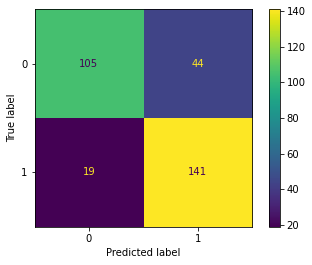

In [ ]:
xbg_binary = train_pred_xgb_optim(X_train_binary_one_hot, y_train_binary_one_hot, X_test_binary_one_hot, y_test_binary_one_hot, avg = 'binary', subsample = 0.85, reg_lambda = 1, n_estimators = 160, max_depth = 4, learning_rate = 0.1, gamma = 0.01)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

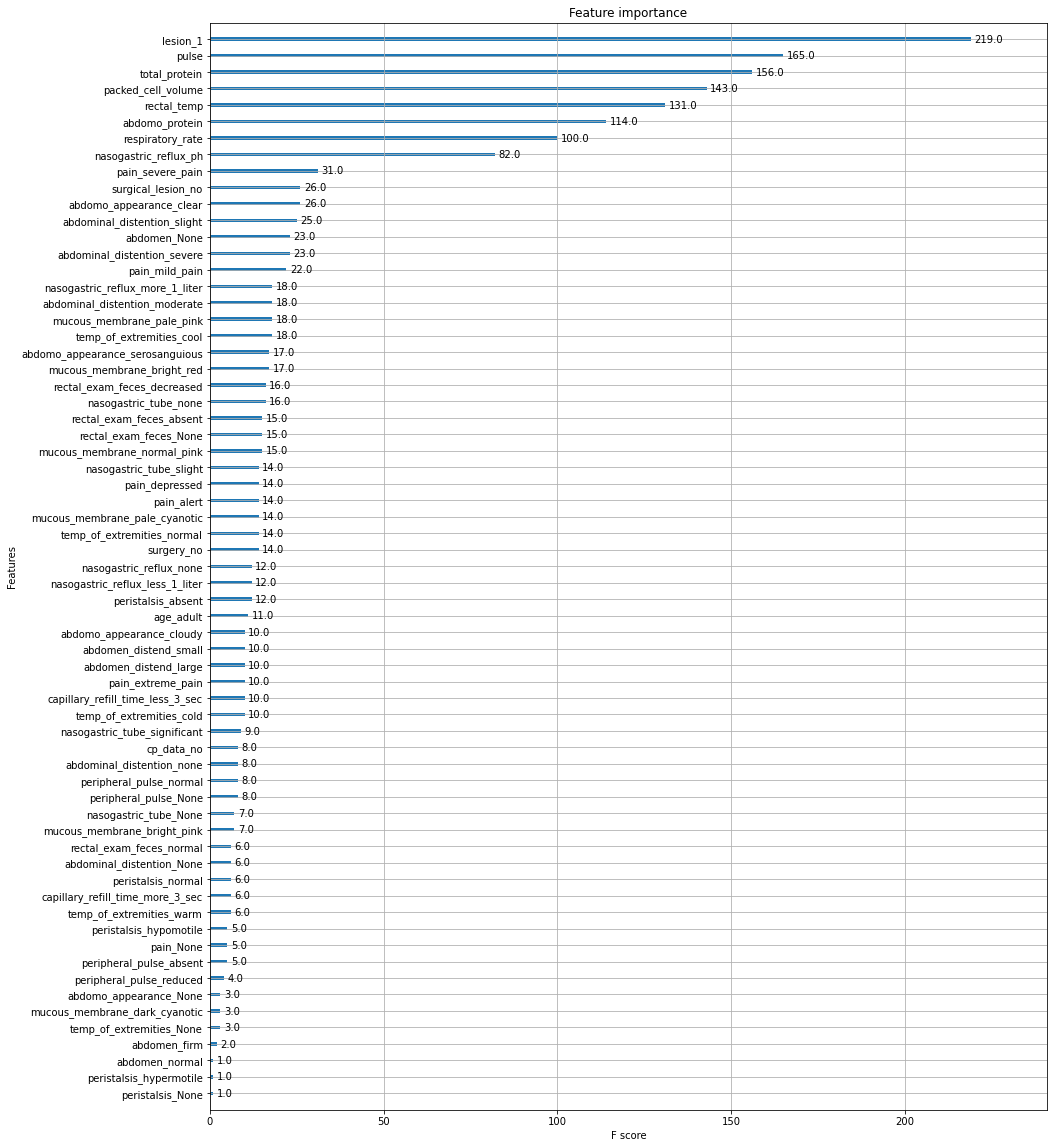

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))

xgb.plot_importance(xbg_binary, ax = ax)

In [ ]:
print('best multi: {}'.format(random_search_multi.best_params_))

best multi: {'subsample': 0.85, 'reg_lambda': 1, 'n_estimators': 110, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.001}


score: 0.7411003236245954
F1: 0.7282499891195543
Precision: 0.7287027091538368
Recall 0.727954978952161


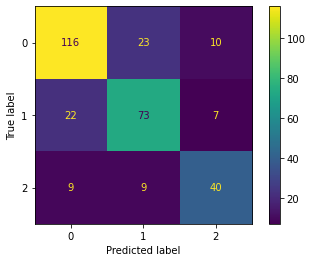

In [ ]:
X_train_multi_one_hot, X_test_multi_one_hot, y_train_multi_one_hot, y_test_multi_one_hot = train_test_split(X_enc_one_hot ,y_multi, 
                                                                            random_state=104,  
                                                                            test_size=0.25,  
                                                                            shuffle=True)
xgb_multi = train_pred_xgb_optim(X_train_multi_one_hot, y_train_multi_one_hot, X_test_multi_one_hot, y_test_multi_one_hot, avg = 'macro', subsample = 0.8, reg_lambda = 1, n_estimators = 60, max_depth = 4, learning_rate = 0.1, gamma = 0.001)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

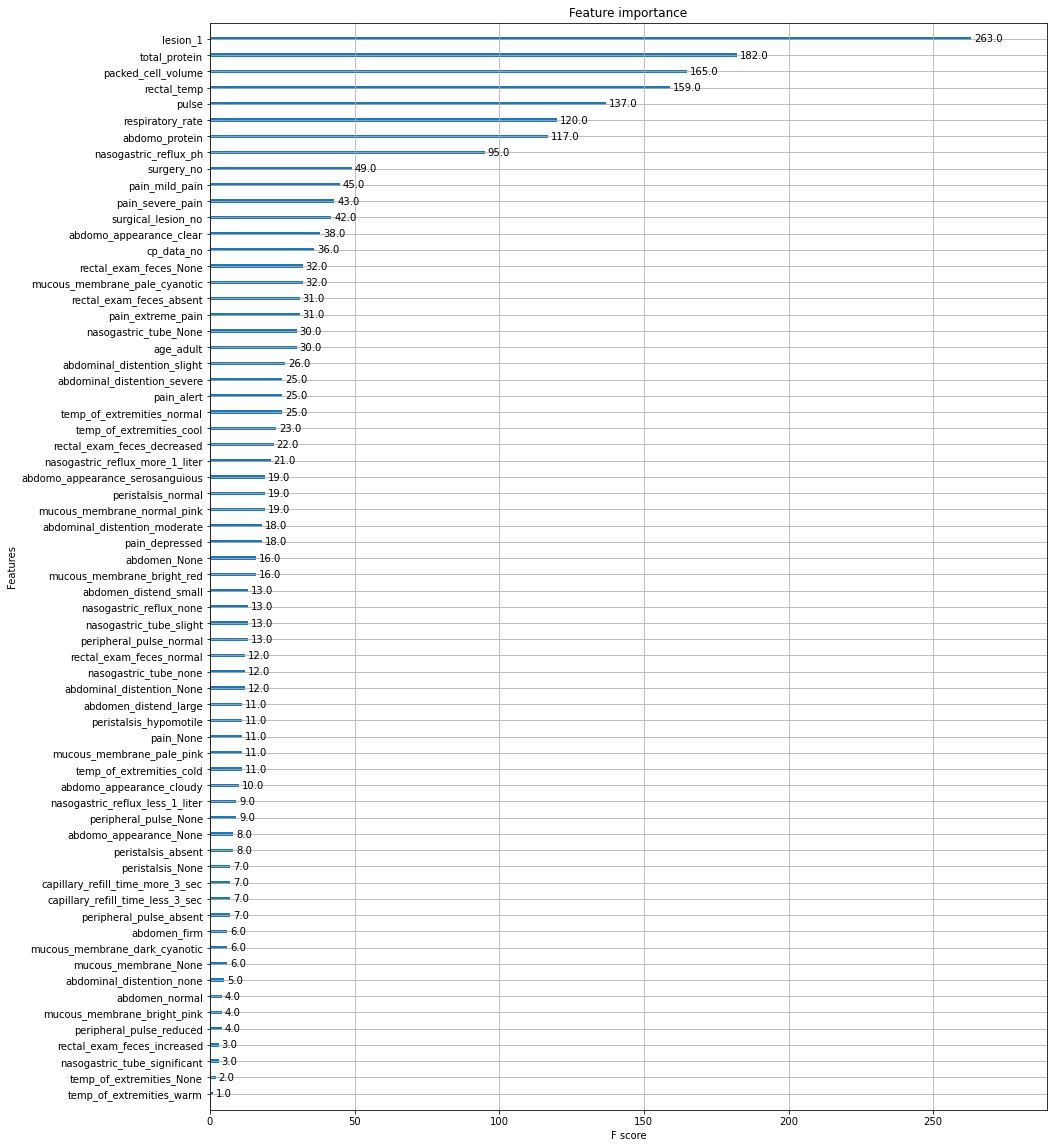

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))

xgb.plot_importance(xgb_multi, ax = ax)

## 4. Custom Pipeline for reusing (XGBoost)

In this section, we will construct a tailored pipeline for the training process of the XGBoost model. The objective is to streamline the preprocessing and other associated tasks.

In [31]:
def custom_pipeline_xgb_train_evaluate(df, case : str):

    temp = df.drop('id', axis = 1, errors= 'ignore')
    temp = df.drop('hospital_number', axis = 1, errors= 'ignore')
    temp['lesion_1'] = temp.lesion_1.apply(str) 
    temp['lesion_2'] = temp.lesion_2.apply(str)
    temp['lesion_3'] = temp.lesion_3.apply(str)
    y_multi = temp.outcome.map({'died': 1, 'lived': 0, 'euthanized': 2 })
    y_binary = temp.binary_outcome.map({'died': 1, 'lived': 0})
    temp = temp.drop('outcome', axis = 1)
    temp = temp.drop('binary_outcome', axis = 1)

    # scaling train and test on X side
    scaler = MinMaxScaler()
    
    numerical = temp.select_dtypes(include=np.number).columns
    
    temp_scaled = temp.copy()
    temp_scaled[numerical] = scaler.fit_transform(temp_scaled[numerical])
    temp_scaled_enc = pd.get_dummies(temp_scaled)

    X = temp_scaled_enc

    #initializing model and splits
    model = None
    avg = ''
    X_train, X_test, y_train, y_test = None, None, None, None
    if(case == 'binary'):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y_binary, 
                                                            random_state=42,  
                                                            test_size=0.25,  
                                                            shuffle=True)
        model = xgb.XGBClassifier(subsample = 0.75, reg_lambda = 1, n_estimators = 60, max_depth = 5, learning_rate = 0.1, gamma = 0.01, verbose = 0)
        avg = 'binary'
    elif (case == 'multi'):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y_multi, 
                                                            random_state=42,  
                                                            test_size=0.25,  
                                                            shuffle=True)
        model = xgb.XGBClassifier(subsample = 0.85, reg_lambda = 1, n_estimators = 110, max_depth = 5, learning_rate = 0.1, gamma = 0.001, verbose = 0)
        avg = 'macro'
    else: 
        raise ValueError('Parameter case should be binary or multi ')

    #training
    model.fit(X_train, y_train)

    #evaluation
    y_pred = model.predict(X_test)

    conf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf).plot()

    print("score: {}".format(accuracy_score(y_test, y_pred)))
    print("F1: {}".format(f1_score(y_test, y_pred, average=avg)))
    print("Precision: {}".format(precision_score(y_test, y_pred, average=avg)))
    print("Recall {}".format(recall_score(y_test, y_pred, average=avg)))

    #feature importance
    fig, ax = plt.subplots(figsize=(15, 20))
    xgb.plot_importance(model, ax = ax)

    return model

score: 0.7313915857605178
F1: 0.726394780926837
Precision: 0.7334981749676205
Recall 0.7213597158802637


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.001, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=110, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

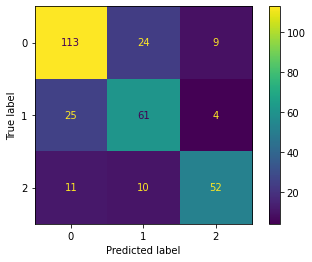

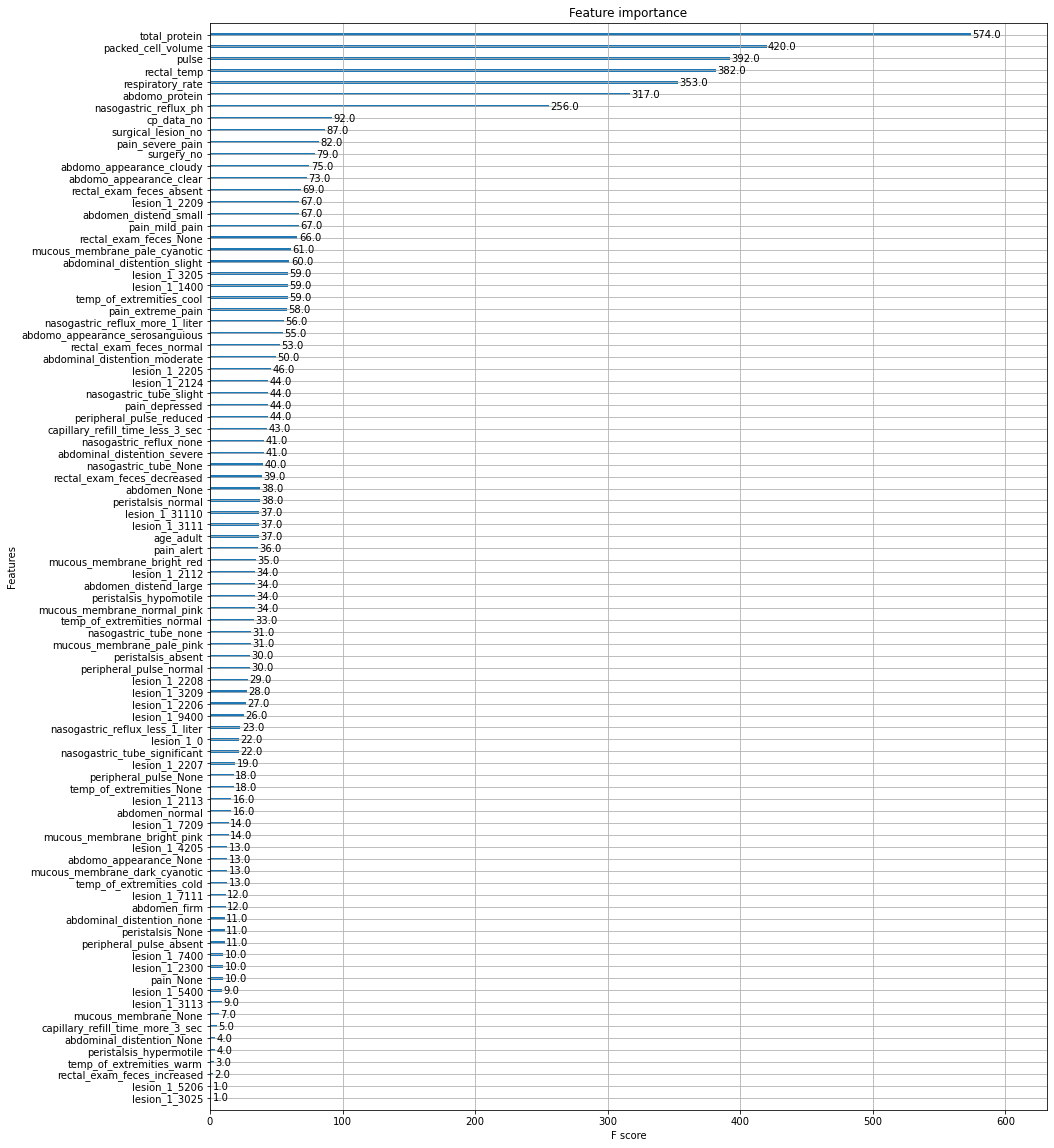

In [38]:
custom_pipeline_xgb_train_evaluate(train_df, 'multi')

## To - Do 

* check distribution between train sample and test (inference) (statistical test)

* the best model should be retrained on the whole train set and then predict the inference data 